In [31]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pickle
import datetime

from torch.utils.data import DataLoader, Subset, ConcatDataset


cudnn.benchmark = True

In [2]:
from torchvision.models import resnet50, ResNet50_Weights


In [3]:
data_dir = 'data/Alzheimer_s Dataset'
synth_dir = 'data/synth'

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
real_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])

synth_dataset = datasets.ImageFolder(synth_dir,
                                     data_transforms['train'])

real_synth_train = ConcatDataset([real_train_dataset, synth_dataset])

real_test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'),
                                          data_transforms['test'])

In [18]:
all_training_sets = {
    'real': real_train_dataset,
    'real_synth': real_synth_train,
    'synth': synth_dataset
}

In [35]:
TRAIN_SET_NAME = 'synth'
image_datasets = {
    'train': all_training_sets[TRAIN_SET_NAME],
    'test': real_test_dataset
}

In [36]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=128,
                                              shuffle=True,
                                              num_workers=4)
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

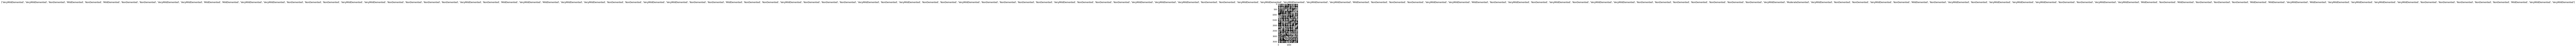

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    metrics_loss = []
    metrics_acc = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            metrics_loss.append(float(epoch_loss))
            metrics_acc.append(float(epoch_acc))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, {'loss': metrics_loss, 'accuracy': metrics_acc}

In [38]:
weights = ResNet50_Weights.IMAGENET1K_V2
preprocess = weights.transforms()

model_ft = resnet50(weights=weights)
num_ftrs = model_ft.fc.in_features

In [39]:
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft, metrics = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 0.2401 Acc: 0.9329
test Loss: 5.8290 Acc: 0.1000

Epoch 1/99
----------
train Loss: 0.1054 Acc: 0.9674
test Loss: 6.8044 Acc: 0.1375

Epoch 2/99
----------


In [42]:
pd.DataFrame(data={'dataset': ['real']
                   'best train acc':[0.5695],
                   'best_test_acc': [0.548438],
                   'epochs': [100]}
            )

SyntaxError: invalid syntax (3488387611.py, line 2)

In [ ]:
fn_datetime_prefix = datetime.datetime.now().strftime(f'%Y_%m_%d_%H_%M')
torch.save(model_ft, f'{fn_datetime_prefix}__{TRAIN_SET_NAME}_model.pt')
with open(f'{fn_datetime_prefix}__{TRAIN_SET_NAME}_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)
    